# Predictions of Healthcare Crises Based on Social Determinants

In this notebook we will perform exploratory regressions to see how to predict healthcare crises based on social determinants.

## Importing Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

## Loading Data

We need the county level data for social determinants and healthcare crises to do the regressions. We only have social determinants for 6 counties in Idaho, so we limit our analysis to those counties.

In [2]:
socialDeterminants = pd.read_parquet('data/CensusSocialDeterminantsCountyRates2014to2017Compressed.parquet.gzip')

vitalStatistics = pd.read_parquet('data/VitalStatsCountyMortality2014to2017Compressed.parquet.gzip', engine='pyarrow')
# Adding the Idaho state Fips back
vitalStatistics['State Fips'] = 16


#Merging the data
finalDf=socialDeterminants.merge(vitalStatistics, left_on=['year', 'county', 'state'], right_on=['Year', 'County Fips', 'State Fips'])
finalDf

total from foodstamp  foodstamp allocated  total from poverty level  \
0                 159896                 2574                    324260   
1                  30240                  729                     61564   
2                  36420                  504                     76571   
3                  66791                 1379                    144615   
4                  56177                 1326                    114468   
5                  29482                  540                     60052   
6                 163585                 3199                    331976   
7                  30174                 1005                     61449   
8                  36702                  370                     78160   
9                  68220                  703                    149570   
10                 58675                  907                    117276   
11                 30177                  439                     60775   
12                167026                 3826                    340421   
13                 30106                  432                     62130   
14                 38464                  684                     79997   
15                 69859                  783                    153954   
16                 58875                  541                    121395   
17                 30119                  325                     61874   
18                171009                 1773                    350497   
19                 31384                  564                     64736   
20                 41118                  339                     82287   
21                 72684                 1299                    159288   
22                 60383                 1058                    124625   
23                 30845                  345                     62724   

    total below poverty level  total from housing rates  people with housing  \
0                       35228                    107590                79623   
1                       10231                     21363                13898   
2                       11043                     26052                16851   
3                       22170                     43963                31859   
4                       12313                     37243                25260   
5                        7753                     19770                12121   
6                       39261                    110914                81578   
7                       15236                     18848                11010   
8                        9748                     24863                15519   
9                       22040                     47411                33090   
10                      15668                     40992                27621   
11                       7542                     20297                13877   
12                      36561                    114084                84049   
13                       9671                     21402                13677   
14                       7457                     26800                17409   
15                      22201                     46524                32727   
16                      16603                     38344                25134   
17                       7835                     20631                12820   
18                      39306                    117660                82461   
19                       8887                     21157                13140   
20                       6686                     29366                18416   
21                      24340                     47084                33282   
22                      10419                     44103                30423   
23                       8462                     22991                15046   

    state  county  total from health insurance  \
0      16       1                       420062   
1      16       5          

Merged data set on county and year, we get 4 years worth of data for 6 counties, or 24 rows in total

# Calculate social determinate rates

In [3]:
finalDf['foodstamp allocation rate']=finalDf['foodstamp allocated']/finalDf['total from foodstamp'] # Compute proportions of social determinants
finalDf['population rate below poverty level']=finalDf['total below poverty level']/finalDf['total from poverty level']
finalDf['rate housing units with morgage']=finalDf['people with housing']/finalDf['total from housing rates']
finalDf['people with health insurance coverage']=finalDf['with health insurance coverage']/finalDf['total from health insurance']
finalDf.head()

total from foodstamp  foodstamp allocated  total from poverty level  \
0                159896                 2574                    324260   
1                 30240                  729                     61564   
2                 36420                  504                     76571   
3                 66791                 1379                    144615   
4                 56177                 1326                    114468   

   total below poverty level  total from housing rates  people with housing  \
0                      35228                    107590                79623   
1                      10231                     21363                13898   
2                      11043                     26052                16851   
3                      22170                     43963                31859   
4                      12313                     37243                25260   

   state  county  total from health insurance  with health insurance coverage  \
0     16       1                       420062                          380900   
1     16       5                        82306                           73813   
2     16      19                       107144                           94867   
3     16      27                       201617                          163816   
4     16      55                       145409                          123240   

   ...  Low Birth Weight Very Low Birth Weight  Moderately Low Birth Weight  \
0  ...               330                    49                          281   
1  ...                81                     7                           74   
2  ...               148                    25                          123   
3  ...               211                    28                          183   
4  ...                89                    20                           69   

   Infant Deaths  County Fips  State Fips  foodstamp allocation rate  \
0             23            1          16                   0.016098   
1              7            5          16                   0.024107   
2             14           19          16                   0.013839   
3             20           27          16                   0.020646   
4              8           55          16                   0.023604   

   population rate below poverty level  rate housing units with morgage  \
0                             0.108641                         0.740059   
1                             0.166185                         0.650564   
2                             0.144219                         0.646822   
3                             0.153304                         0.724678   
4                             0.107567                         0.678248   

   people with health insurance coverage  
0                               0.906771  
1                               0.896812  
2                               0.885416  
3                               0.812511  
4                               0.847540  

[5 rows x 37 columns]

Now that we have the rates, let's see how well they can predicate our #1 Health crisis. 

***Note:*** We only have 4 data points and we really should have 10 at a absolute minimum.

## Social Determinants Predicting Alzheimers Disease in Ada County

In [4]:
uniqueNames = finalDf['county'].unique() # Create a list of the County FIPS codes we have data for
dataFrameDict = {elem : pd.DataFrame for elem in uniqueNames} # Convert previous list to a dictionary

for key in dataFrameDict.keys(): # Create 6 dataframes for the different counties
    dataFrameDict[key] = finalDf[:][finalDf['county'] == key]

result1 = sm.OLS(finalDf['Death From Alzheimers Disease'], finalDf['population rate below poverty level']).fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Death From Alzheimers Disease   R-squared (uncentered):               -1544.445
Model:                                       OLS   Adj. R-squared (uncentered):          -1611.638
Method:                            Least Squares   F-statistic:                             -22.99
Date:                           Wed, 11 Dec 2019   Prob (F-statistic):                        1.00
Time:                                   13:27:00   Log-Likelihood:                         -132.97
No. Observations:                             24   AIC:                                      267.9
Df Residuals:                                 23   BIC:                                      269.1
Df Model:                                      1                                                  
Covariance Type:                       nonrobust                                                  
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
population rate below poverty level   422.5773     94.440      4.475      0.000     227.213     617.942
==============================================================================
Omnibus:                       15.231   Durbin-Watson:                   2.479
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.826
Skew:                           1.647   Prob(JB):                     0.000603
Kurtosis:                       4.993   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As you can see with the data we have we got a P of 0, but so much more is so wrong with this. -1544.445 for R-squared that stands out. So will so little data we really can't do anything

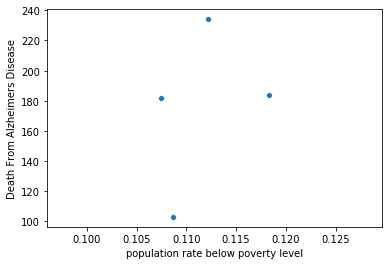

In [5]:
plot1 = sns.scatterplot(x="population rate below poverty level", y="Death From Alzheimers Disease", data=dataFrameDict[1])

In [6]:
result2 = sm.OLS(finalDf['Death From Alzheimers Disease'], finalDf['foodstamp allocation rate']).fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Death From Alzheimers Disease   R-squared (uncentered):               -1526.568
Model:                                       OLS   Adj. R-squared (uncentered):          -1592.984
Method:                            Least Squares   F-statistic:                             -22.98
Date:                           Wed, 11 Dec 2019   Prob (F-statistic):                        1.00
Time:                                   13:27:00   Log-Likelihood:                         -132.83
No. Observations:                             24   AIC:                                      267.7
Df Residuals:                                 23   BIC:                                      268.8
Df Model:                                      1                                                  
Covariance Type:                       nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
foodstamp allocation rate  3359.9923    741.644      4.530      0.000    1825.784    4894.200
==============================================================================
Omnibus:                       13.840   Durbin-Watson:                   2.404
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.183
Skew:                           1.437   Prob(JB):                      0.00137
Kurtosis:                       5.219   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

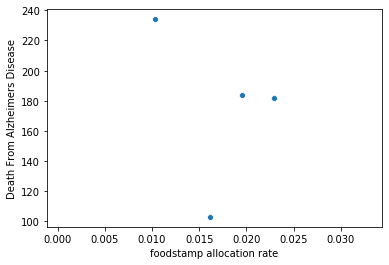

In [7]:
plot2 = sns.scatterplot(x="foodstamp allocation rate", y="Death From Alzheimers Disease", data=dataFrameDict[1])

In [8]:
result3 = sm.OLS(finalDf['Death From Alzheimers Disease'], finalDf['rate housing units with morgage']).fit()
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Death From Alzheimers Disease   R-squared (uncentered):               -1200.576
Model:                                       OLS   Adj. R-squared (uncentered):          -1252.819
Method:                            Least Squares   F-statistic:                             -22.98
Date:                           Wed, 11 Dec 2019   Prob (F-statistic):                        1.00
Time:                                   13:27:00   Log-Likelihood:                         -129.95
No. Observations:                             24   AIC:                                      261.9
Df Residuals:                                 23   BIC:                                      263.1
Df Model:                                      1                                                  
Covariance Type:                       nonrobust                                                  
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
rate housing units with morgage    96.1136     16.903      5.686      0.000      61.148     131.080
==============================================================================
Omnibus:                       19.141   Durbin-Watson:                   2.385
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.550
Skew:                           1.920   Prob(JB):                     2.09e-05
Kurtosis:                       5.608   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

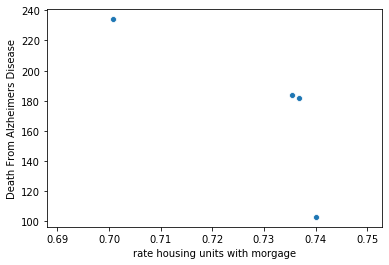

In [9]:
plot3 = sns.scatterplot(x="rate housing units with morgage", y="Death From Alzheimers Disease", data=dataFrameDict[1])

In [10]:
plot3a = sns.regplot(x='rate housing units with morgage', y='Death From Alzheimers Disease', data=dataFrameDict[1])

In [11]:
result4 = sm.OLS(finalDf['Death From Alzheimers Disease'], finalDf['people with health insurance coverage']).fit()
result4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Death From Alzheimers Disease   R-squared (uncentered):               -1295.930
Model:                                       OLS   Adj. R-squared (uncentered):          -1352.319
Method:                            Least Squares   F-statistic:                             -22.98
Date:                           Wed, 11 Dec 2019   Prob (F-statistic):                        1.00
Time:                                   13:27:02   Log-Likelihood:                         -130.86
No. Observations:                             24   AIC:                                      263.7
Df Residuals:                                 23   BIC:                                      264.9
Df Model:                                      1                                                  
Covariance Type:                       nonrobust                                                  
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
people with health insurance coverage    70.0853     13.183      5.317      0.000      42.815      97.356
==============================================================================
Omnibus:                       17.042   Durbin-Watson:                   2.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.656
Skew:                           1.803   Prob(JB):                     0.000147
Kurtosis:                       5.158   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
plot4 = sns.scatterplot(x="people with health insurance coverage", y="Death From Alzheimers Disease", data=dataFrameDict[1])

In [13]:
plot4a = sns.regplot(x='people with health insurance coverage', y='Death From Alzheimers Disease', data=dataFrameDict[1])

So, as you can see the plots and summaries are quite insane. We can predict anything will so few data points. As one of our plots "shows" more health insurance coverage means more deaths. That couldn't be further from the truth.

I'll we have shown is we need more data. Unfortutaly we couldn't locate any additional data for this project, mainly due to the highly sensitive nature of this type of data.